In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import json
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.metrics import f1

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
f_model = resnet34
PATH = 'data/iMaterialist/'
sz=224

In [6]:
ls {PATH}

labels.csv                                     train_10k/
labels.gz                                      train_10kv2/
models/                                        train_10kv2_labels.csv
sample_submission.csv                          train_30k/
submission_resnet34_train_10kv2_0.47985.csv    train_30k_labels.csv
submission_resnext50_train_10kv2_0.471314.csv  train.json
test/                                          train.json.zip
test.json                                      valid/
test.json.zip                                  validation.json
tmp/                                           validation.json.zip


In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

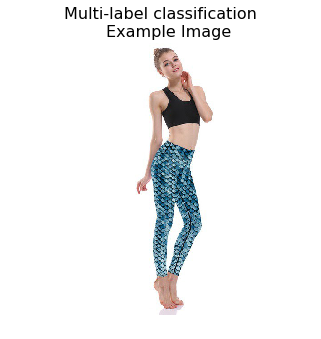

In [9]:
fn = get_1st(f'{PATH}train_30k')
plots_from_files([fn], titles=['Example Image'], maintitle="Multi-label classification")

In [12]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
val_idxs = get_cv_idxs(30000)
data = ImageClassifierData.from_csv(PATH, 'train_30k', f'{PATH}train_30k_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

In [13]:
learn = ConvLearner.pretrained(f_model, data, precompute=True, metrics=[f1])

100%|██████████| 94/94 [00:18<00:00,  5.06it/s]


## Step 1

First we begin retraining the last layer to map training images to our new labels. Because we do not need to send images through all but the last layer more than once, we turn on precompute to cache the vector embeddings before training the last fully connected logistic regression layer.

 89%|████████▊ | 352/397 [00:05<00:00, 60.38it/s, loss=0.307]


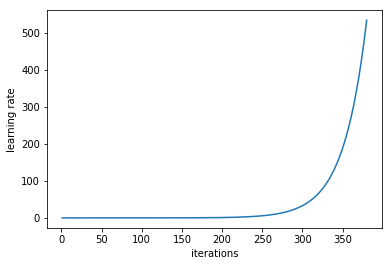

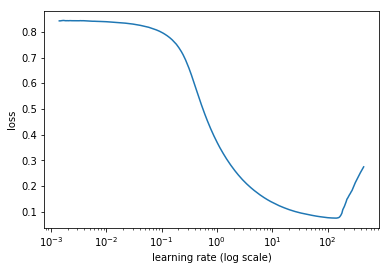

In [14]:
learn.lr_find(start_lr=1e-3, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

We started to see overfitting after 4 epochs. We will stop this initial training at 4 epochs

In [15]:
learn.fit(10, 4)

epoch      trn_loss   val_loss   f1         
    0      0.046433   0.043437   0.372338  
    1      0.044901   0.04179    0.385674  
    2      0.043507   0.041249   0.406214  
    3      0.042349   0.040347   0.418676  



[array([0.04035]), 0.4186755969912565]

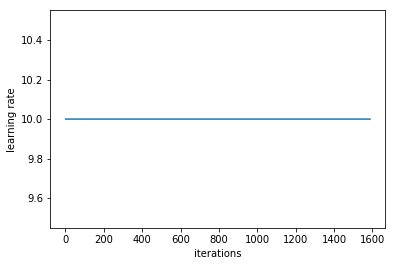

In [16]:
learn.sched.plot_lr()

## Step 2

Lets turn off precompute so we can use randomized crops / brightness levels / zooms for side-on image transformations. We will also add in some cycling of learning rates

In [17]:
learn.precompute=False

In [18]:
learn.fit(10, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.042066   0.039648   0.422383  
    1      0.041708   0.039498   0.424354  
    2      0.040946   0.039381   0.422105  



[array([0.03938]), 0.42210514447977054]

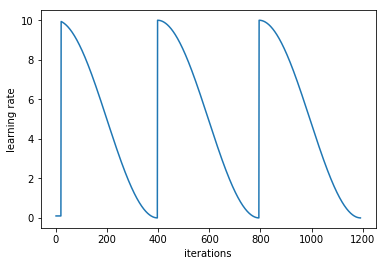

In [19]:
learn.sched.plot_lr()

## Step 3

Let's now tune the beginning, middle, and last layers with a couple more epochs and multiple the cycle len

 96%|█████████▌| 382/397 [01:24<00:03,  4.51it/s, loss=0.16] 

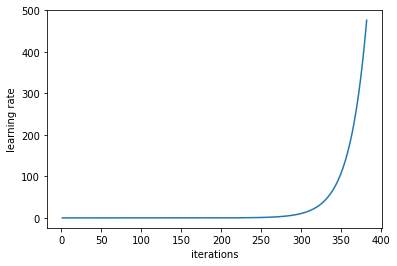

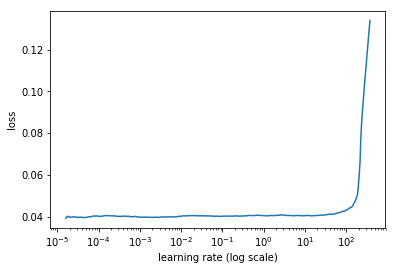

In [20]:
learn.lr_find(start_lr=1e-5, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [21]:
learn.unfreeze()
lr=np.array([0.001, 0.01, 0.1])
learn.fit(lr, 3, cycle_len=1)

  2%|▏         | 7/397 [00:03<03:05,  2.11it/s, loss=0.0433]
epoch      trn_loss   val_loss   f1         
    0      0.042058   0.040569   0.409186  
    1      0.041201   0.04       0.416078  
    2      0.040718   0.039698   0.419271  



[array([0.0397]), 0.4192712318783624]

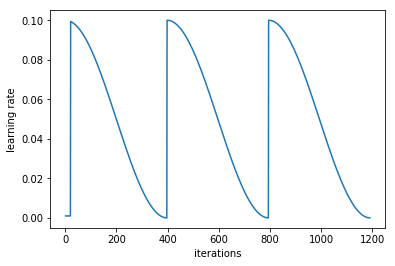

In [22]:
learn.sched.plot_lr()

try again with higher learning rate

In [23]:
lr=np.array([0.01, 0.1, 1.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.039838   0.038678   0.435439  
    1      0.03909    0.038194   0.442422  
    2      0.03893    0.037826   0.448114  



[array([0.03783]), 0.44811432973682386]

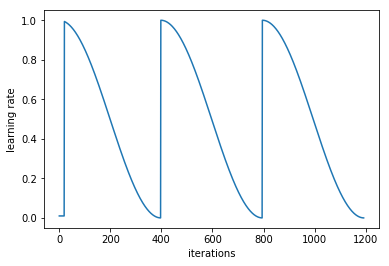

In [24]:
learn.sched.plot_lr()

In [25]:
lr=np.array([0.05, 0.5, 5.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.038437   0.037391   0.460434  
    1      0.037298   0.036887   0.47319   
    2      0.036309   0.036719   0.478577  



[array([0.03672]), 0.47857730056567593]

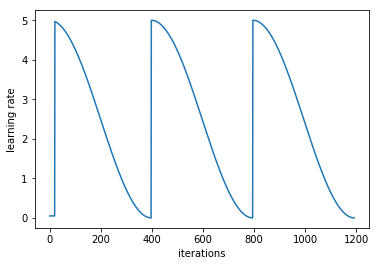

In [26]:
learn.sched.plot_lr()

In [27]:
lr=np.array([0.1, .8, 5.0])
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   f1         
    0      0.036284   0.036473   0.484515  
    1      0.03537    0.036272   0.489767  
    2      0.034204   0.036099   0.494236  



[array([0.0361]), 0.4942356229493236]

In [28]:
learn.save('temp')

## Step 4

Lets change the size so we avoid overfitting

In [29]:
sz=299
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_csv(PATH, 'train_30k', f'{PATH}train_30k_labels.csv', tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

learn.set_data(data)
learn.freeze()

 96%|█████████▌| 382/397 [02:16<00:05,  2.79it/s, loss=0.134]

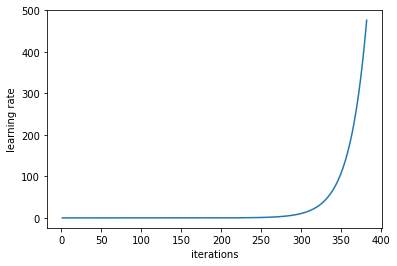

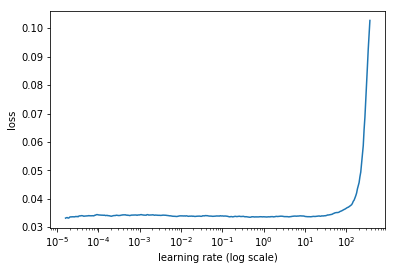

In [30]:
learn.lr_find(start_lr=1e-5, end_lr=1e3)
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

  4%|▍         | 15/397 [00:06<02:37,  2.42it/s, loss=0.0339]
epoch      trn_loss   val_loss   f1         
    0      0.034059   0.036162   0.490945  
    1      0.033614   0.036128   0.490907  
    2      0.033657   0.036067   0.493182  



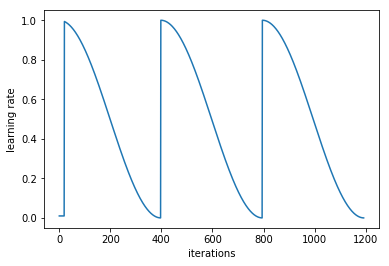

In [31]:
learn.fit(1.0, 3, cycle_len=1)
learn.sched.plot_lr()

In [76]:
learn.save('temp')

Now we want to unfreeze the earlier layers and retrain with larger images

epoch      trn_loss   val_loss   f1         
    0      0.033963   0.035604   0.505353  
    1      0.032868   0.035665   0.505481  
    2      0.031782   0.035515   0.508686  



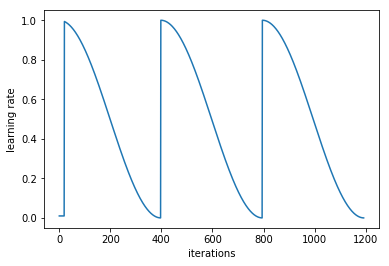

In [32]:
learn.unfreeze()
learn.fit([0.1, 0.5, 1.], 3, cycle_len=1)
learn.sched.plot_lr()

In [33]:
learn.save('resnet34_train_30k_0.508686')

# Load Model and score on test data

In [16]:
# f_model = resnet34
# PATH = 'data/iMaterialist/'
# sz=299

# tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
# val_idxs = get_cv_idxs(10000)
# data = ImageClassifierData.from_csv(PATH, 'train_10kv2', f'{PATH}train_10kv2_labels.csv',
#                                     tfms=tfms, val_idxs=val_idxs, suffix='.jpg', test_name='test')

# learn = ConvLearner.pretrained(f_model, data, precompute=False, metrics=[f1])
# learn.load('resnet34_train_10kv2_0.47985')

In [34]:
multi_preds, y = learn.TTA(is_test=True)
preds = np.mean(multi_preds, 0)

This generates a label for each multilabel where score > 0.5

In [97]:
def save_results_to_csv(model, preds, threshold):
    cs = np.array(model.data.classes)
    label_preds = list(map(lambda x: ' '.join(cs[x]), (preds > threshold)))
    test_ids = list(map(lambda x: int(x[5:-4]), model.data.test_ds.fnames))
    
    pred_df = (
        pd.DataFrame(list(zip(test_ids, label_preds)),
                     columns=['image_id', 'label_id'])
        .sort_values('image_id')
        .reset_index(drop=True)
    )
    
    with open('data/iMaterialist/test.json') as f:
        test_urls = pd.DataFrame(json.load(f)['images'])

    with open('data/iMaterialist/validation.json') as f:
        j = json.load(f)
        valid_urls = pd.DataFrame(j['images'])
        valid_labels = pd.DataFrame(j['annotations'])
        valid_labels['labelId'] = valid_labels['labelId'].apply(lambda x: ' '.join(x))
        valid = valid_urls.merge(valid_labels, how='inner', on='imageId')[['url', 'labelId']]
    test_labels = test_urls.merge(valid, how='inner', on='url').drop('url', axis=1)
    
    pred_df.loc[:9896, 'label_id'] = test_labels['labelId'].values
    pred_df.to_csv(f'data/iMaterialist/submission_resnet34_train_30k_0.508686_t_{str(threshold)}.csv', index=False)
    

In [98]:
save_results_to_csv(learn, preds, 0.1)